# State of Charge/State of Health Estimation Framework using Center for Advanced Life Cycle Engineering Data

In [1]:
# Load all necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import tensorflow
from tensorflow.keras import Model 
from tensorflow.keras.layers import Dense, Conv1D, Bidirectional, GRU, Input, Concatenate, Masking
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

AttributeError: module 'numpy' has no attribute 'typeDict'

In [73]:
# Load helper scripts
%load_ext autoreload
%autoreload 2
import helper_functions as help_func
import plotting_utilities as plot_util
import config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load saved data for faster use
df_subcycle_35 = pd.read_csv('data/calce_subcycle_data_35.csv')
df_subcycle_36 = pd.read_csv('data/calce_subcycle_data_36.csv')
df_subcycle_37 = pd.read_csv('data/calce_subcycle_data_37.csv')
df_subcycle_38 = pd.read_csv('data/calce_subcycle_data_38.csv')
df = pd.read_csv('data/calce_cycling_data.csv')

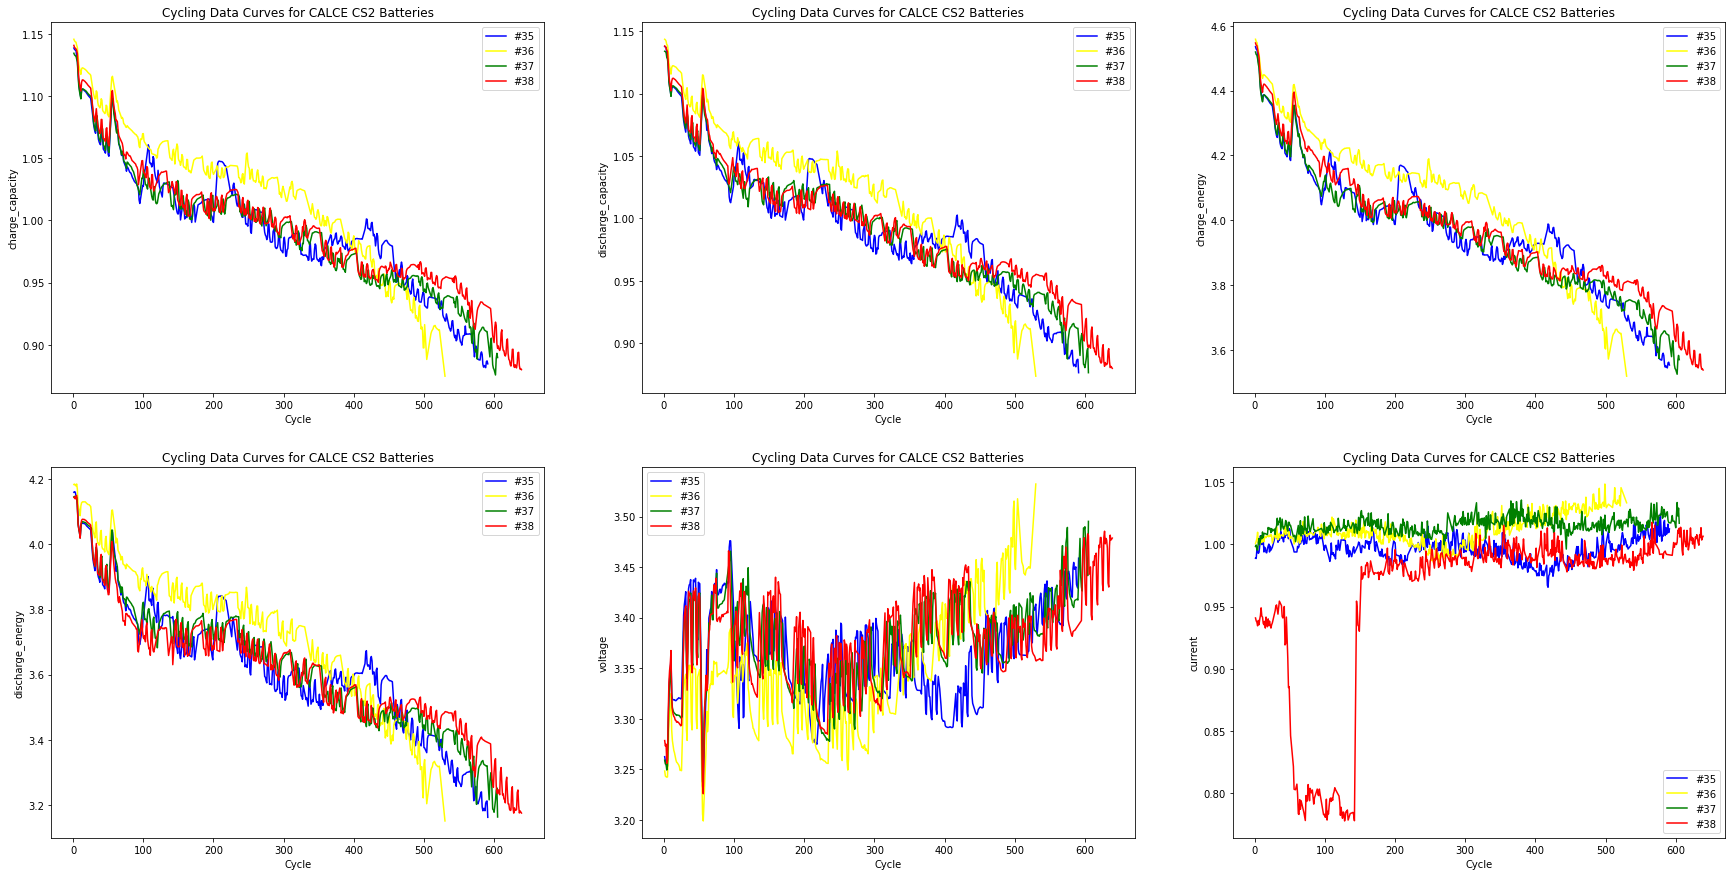

In [14]:
# Plot cycling data's available features after filtering outliers
fig, axs = plt.subplots(2, 3, figsize=(30, 15))
row = 0
col = 0
for feat in config.col_for_filtering:
    axs[row, col].plot(df[df['cell_number'] == 35]['cycle'].to_numpy(), df[df['cell_number'] == 35][feat].to_numpy(), color='blue', label='#35')
    axs[row, col].plot(df[df['cell_number'] == 36]['cycle'].to_numpy(), df[df['cell_number'] == 36][feat].to_numpy(), color='yellow', label='#36')
    axs[row, col].plot(df[df['cell_number'] == 37]['cycle'].to_numpy(), df[df['cell_number'] == 37][feat].to_numpy(), color='green', label='#37')
    axs[row, col].plot(df[df['cell_number'] == 38]['cycle'].to_numpy(), df[df['cell_number'] == 38][feat].to_numpy(), color='red', label='#38')
    if col == 'discharge_capacity':
        axs[row, col].axhline(y=config.nominal_capacity*config.eol, color='black', linestyle='--', label='80% State of Health')
    axs[row, col].legend()
    axs[row, col].set_title('Cycling Data Curves for CALCE CS2 Batteries')
    axs[row, col].set_xlabel('Cycle')
    axs[row, col].set_ylabel(feat)
    if col == 2:
        row = 1
        col = 0
    else:
        col += 1
plt.show()

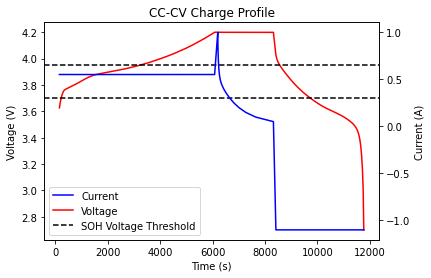

In [15]:
# Plot one cycle of the charge distrubtuion to get an idea of what CC/CV looks like and the voltage range used for SOH
df_subcycle_temp = df_subcycle_35[df_subcycle_35['Cycle_Index'] == 100]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
steps = list(df_subcycle_temp.Step_Index.unique())
ax1.plot(df_subcycle_temp['Test_Time(s)'].to_numpy(), df_subcycle_temp ['Voltage(V)'].to_numpy(), color='red', label='Voltage') 
ax2.plot(df_subcycle_temp['Test_Time(s)'].to_numpy(), df_subcycle_temp['Current(A)'].to_numpy(), color='blue', label='Current') 
ax1.axhline (y=3.7, color = 'black', Linestyle= '--', label='SOH Voltage Threshold')
ax1.axhline (y=3.95, color = 'black', Linestyle='--')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax2.set_ylabel('Current (A)')
plt.title('CC-CV Charge Profile')
for s in steps:
    df_temp = df_subcycle_temp[df_subcycle_temp['Step_Index']==s]
    max_time = max(df_temp['Test_Time(s)'])
    l = 'End Step' + str(s)
#plt.axvLine(x = max_time, color = 'black', Label = L, Linestyle='--') 
plt.plot([], [], color='red', label='Voltage')
plt.plot([], [], color='black', LInestyle='--', label='SOH Voltage Threshold')
plt.legend(loc=3)
plt.show()

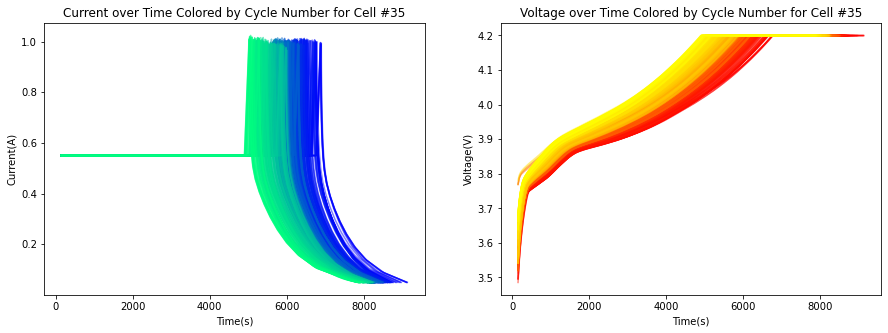

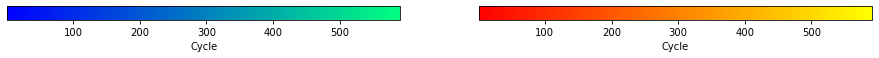

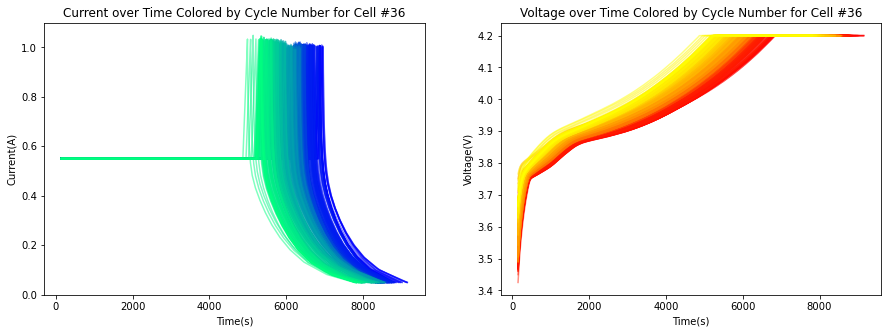

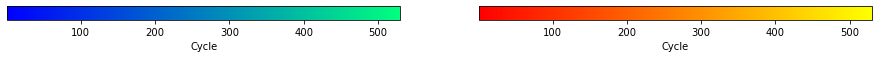

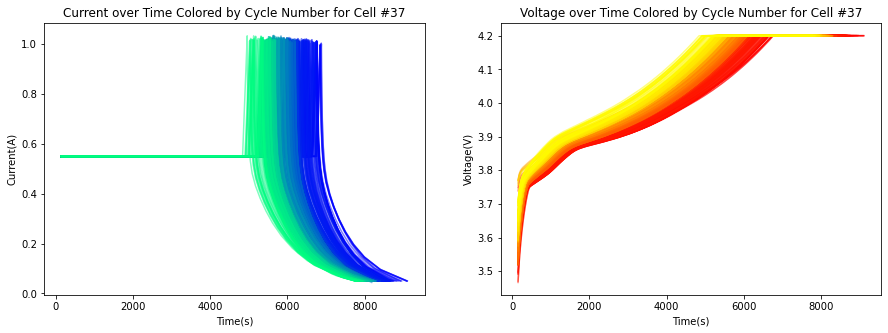

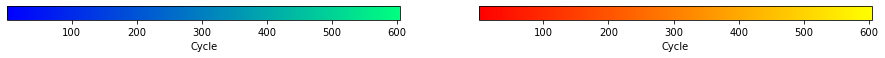

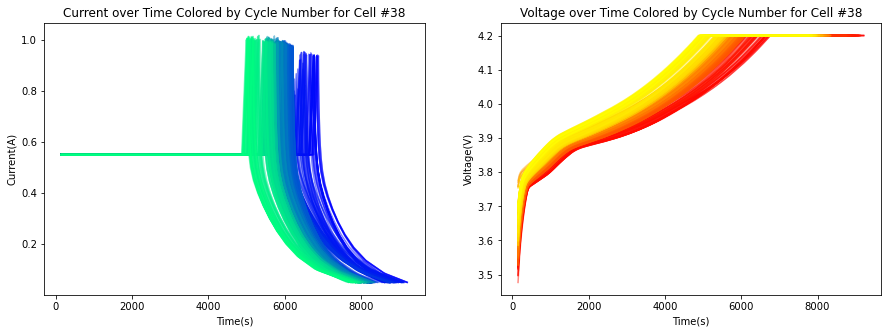

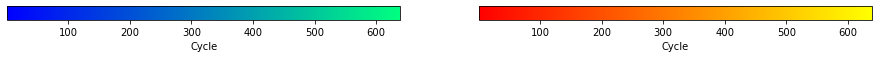

In [75]:
plot_util.plot_subcycle_data(df_subcycle_35, 'Current(A)', 'Voltage(V)', 35)
plot_util.plot_subcycle_data(df_subcycle_36, 'Current(A)', 'Voltage(V)', 36)
plot_util.plot_subcycle_data(df_subcycle_37, 'Current(A)', 'Voltage(V)', 37)
plot_util.plot_subcycle_data(df_subcycle_38, 'Current(A)', 'Voltage(V)', 38)